# The relationship between pupil size and activity in visual cortex

## Imports and constants

In [1]:
from datamatrix import io, plot
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datamatrix import operations as ops, DataMatrix, FloatColumn

In [2]:
MAX_ERR = np.inf
MIN_X = 4
MAX_X = 156
MIN_Y = 4
MAX_Y = 124
MIN_SD = 1
MAX_SD = 60
XC = 80
YC = 64
SRC_NIFTI = '../outputs/correlation-matrix.pkl'
SRC_LONGISH = '../outputs/longish-correlation-matrix.csv'

## Read data

The data is read in two formats:

- A DataMatrix `dm` with one row for each roi/ subject, and the imaging data as NiftiColumns
- A "longish" DataMatrix `ldm` with one row for each voxel

The data is filtered based on the PRF properties to avoid poorly fitted PRFs from being included in the analysis.

In [3]:
def mask(nft, mask):
    
    """Set voxels that match the mask to nan"""
    
    nft.get_data()[mask] = np.nan


dm = io.readpickle(SRC_NIFTI)
ldm = io.readtxt(SRC_LONGISH)
for row in dm:
    a = row.prf_err.get_data()
    x = row.prf_x.get_data()
    y = row.prf_y.get_data()
    sd = row.prf_sd.get_data()
    err = np.where(
        (a > MAX_ERR) |
        (x < MIN_X) | (x >= MAX_X) |
        (y < MIN_Y) | (y >= MAX_Y) |
        (sd < MIN_SD) | (sd >= MAX_SD)
    )
    n_poor = len(err[0])
    n_total = np.sum(~np.isnan(a))
    mask(row.prf_x, err)
    mask(row.prf_y, err)
    mask(row.prf_sd, err)
    mask(row.prf_err, err)
    mask(row.r_vc_pupil, err)
    mask(row.r_vc_lum, err)
dm.r_pupil = [np.nanmedian(row.r_vc_pupil.get_data()) for row in dm]
dm.r_lum = [np.nanmedian(row.r_vc_lum.get_data()) for row in dm]
dm.m_prf_err = [np.nanmedian(row.prf_err.get_data()) for row in dm]
dm.m_prf_sd = [np.nanmedian(row.prf_sd.get_data()) for row in dm]
dm.m_prf_absx = [np.nanmedian(np.abs(row.prf_x.get_data() - XC)) for row in dm]
dm.m_prf_absy = [np.nanmedian(np.abs(row.prf_y.get_data() - YC)) for row in dm]
dm.m_prf_ecc = [
    np.nanmedian(
        (
            (row.prf_y.get_data() - XC) ** 2 +
            (row.prf_y.get_data() - YC) ** 2
        ) ** .5
    )
    for row in dm
]
print('Total number of voxels: {}'.format(len(ldm)))
ldm = ldm.prf_err <= MAX_ERR
ldm = ldm.prf_x > MIN_X
ldm = ldm.prf_x <= MAX_X
ldm = ldm.prf_y > MIN_Y
ldm = ldm.prf_y <= MAX_Y
print('Number of voxels included in analysis: {}'.format(len(ldm)))

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal


Total number of voxels: 54720
Number of voxels included in analysis: 34941


# Plot: Correlations between pupil size, luminance, and visual-cortex activity

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


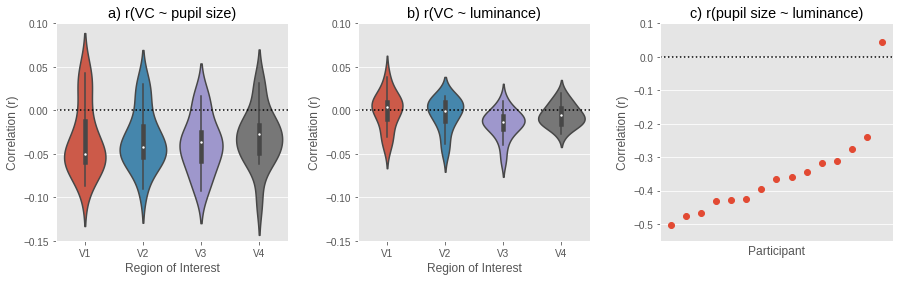

In [4]:
plt.figure(figsize=(15, 4))

plt.subplots_adjust(wspace=.3)
plt.subplot(1,3,1)
plt.ylabel('Correlation (r)')
plt.xlabel('Region of Interest')
plt.title('a) r(VC ~ pupil size)')
plt.axhline(0, color='black', linestyle=':')
plt.ylim(-.15, .1)
sns.violinplot(x='roi', y='r_pupil', data=dm)

plt.subplot(1,3,2)
plt.title('b) r(VC ~ luminance)')
plt.ylabel('Correlation (r)')
plt.axhline(0, color='black', linestyle=':')
sns.violinplot(x='roi', y='r_lum', data=dm)
plt.ylim(-.15, .1)
plt.xlabel('Region of Interest')

plt.subplot(1,3,3)
plt.ylabel('Correlation (r)')
plt.title('c) r(pupil size ~ luminance)')
plt.axhline(0, color='black', linestyle=':')
r = sorted([sdm.r_lum_pupil.mean for sub, sdm in ops.split(dm.sub)])
plt.plot(r ,'o')
plt.xlabel('Participant')
plt.xticks([])
plt.ylim(-.55, .1)

plot.save('correlation-plot', show=True)

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


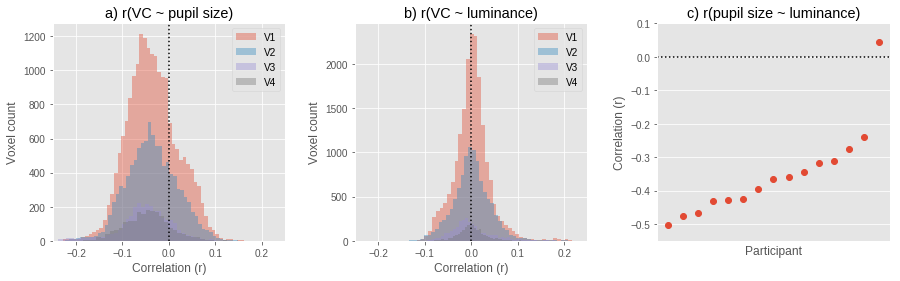

In [5]:
plt.figure(figsize=(15, 4))

plt.subplots_adjust(wspace=.3)
plt.subplot(1,3,1)
plt.title('a) r(VC ~ pupil size)')
plt.xlim(-.25, .25)
plt.axvline(0, color='black', linestyle=':')
for roi, rdm in ops.split(ldm.roi):
    sns.distplot(rdm.r_vc_pupil, label=roi, hist=True, kde=False)
plt.ylabel('Voxel count')
plt.xlabel('Correlation (r)')
plt.legend()

plt.subplot(1,3,2)
plt.title('b) r(VC ~ luminance)')
plt.xlim(-.25, .25)
plt.axvline(0, color='black', linestyle=':')
for roi, rdm in ops.split(ldm.roi):
    sns.distplot(rdm.r_vc_lum, label=roi, hist=True, kde=False)
plt.ylabel('Voxel count')
plt.xlabel('Correlation (r)')
plt.legend()

plt.subplot(1,3,3)
plt.ylabel('Correlation (r)')
plt.title('c) r(pupil size ~ luminance)')
plt.axhline(0, color='black', linestyle=':')
r = sorted([sdm.r_lum_pupil.mean for sub, sdm in ops.split(dm.sub)])
plt.plot(r ,'o')
plt.xlabel('Participant')
plt.xticks([])
plt.ylim(-.55, .1)

plot.save('correlation-plot-dist', show=True)

# Plot: PRF properties

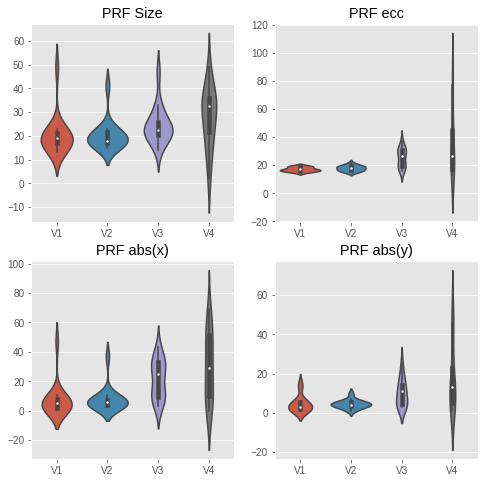

In [6]:
plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
plt.title('PRF Size')
sns.violinplot(x='roi', y='m_prf_sd', data=dm)

plt.subplot(2,2,2)
plt.title('PRF ecc')
sns.violinplot(x='roi', y='m_prf_ecc', data=dm)

plt.subplot(2,2,3)
plt.title('PRF abs(x)')
sns.violinplot(x='roi', y='m_prf_absx', data=dm)
plt.subplot(2,2,4)
plt.title('PRF abs(y)')
sns.violinplot(x='roi', y='m_prf_absy', data=dm)

plot.save('prf-plot', show=True)

# Heatmaps

Various heatmaps to inspect how properties are distributed across the visual field, across all ROIs and for each ROI separately.

First some helper functions.

In [7]:
def density_map(ldm, downsample=8):

    a = np.zeros((2 * XC // downsample, 2 * YC // downsample))
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[x, y] += 1
    plt.axis('off')
    plt.imshow(a)
    
    
def size_map(ldm, downsample=32):

    a = np.empty((len(ldm), 2 * XC // downsample, 2 * YC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.prf_sd
        a[i, x, y] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    plt.imshow(heatmap)
        
    
def correlation_map(ldm, downsample=32):

    a = np.empty((len(ldm), 2 * XC // downsample, 2 * YC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[i, x, y] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    plt.imshow(heatmap, interpolation='none', vmin=-.1, vmax=.1, cmap='jet')

    
    
def roi_plot(ldm, fnc):
        
    plt.figure(figsize=(10, 4))
    plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.subplot(1, 5, 1)
    plt.title('All (V1 - V4)')
    fnc(ldm)    
    plt.subplot(1, 5, 2)
    plt.title('V1')
    fnc(ldm.roi == 'V1')
    plt.subplot(1, 5, 3)    
    plt.title('V2')
    fnc(ldm.roi == 'V2')
    plt.subplot(1, 5, 4)    
    plt.title('V3')
    fnc(ldm.roi == 'V3')
    plt.subplot(1, 5, 5)
    plt.title('V4')
    fnc(ldm.roi == 'V4')


The density of PRFs.

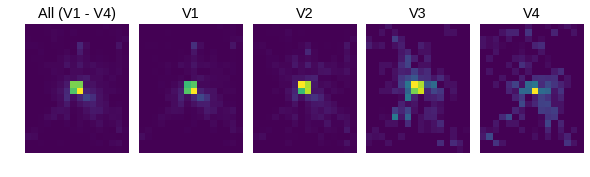

In [8]:
roi_plot(ldm, density_map)
plot.save('map-density', show=True)

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


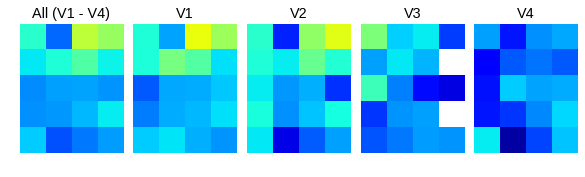

In [9]:
roi_plot(ldm, correlation_map)
plot.save('map-correlation', show=True)

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


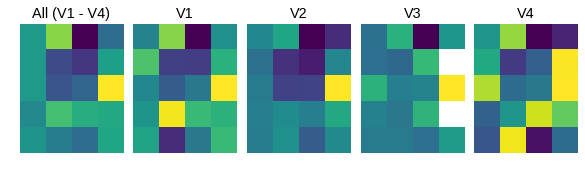

In [10]:
roi_plot(ldm, size_map)
plot.save('map-prf-size', show=True)

# Statistics

In [11]:
from datamatrix.rbridge import lme4
lme4.verbose = True

## Relationship between PRF properties and the VC-pupil correlation.

In [12]:
lme4.lmer(ldm, 'r_vc_pupil ~ (1|sub)')

df,effect,est,p,se,t
14.0006202333549,(Intercept),-0.0372088359247735,0.000533877179428175,0.00833366518342876,-4.46488251037037


In [13]:
lme4.lmer(ldm, 'r_vc_pupil ~ r_vc_lum + (1+r_vc_lum|sub)')

df,effect,est,p,se,t
14.6301593855149,(Intercept),-0.0363272211299896,0.000134899046759108,0.00709031580124652,-5.12349832480002
15.851814400577,r_vc_lum,-0.542443208581901,0.00025426693258979,0.115778486496481,-4.68518137519777


In [14]:
ldm.c_roi = ldm.roi @ (lambda roi: 0 if roi == 'V1' else 1 if roi == 'V2' else 2 if roi == 'V3' else 3)
lme4.lmer(ldm, 'r_vc_pupil ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0003818789515,(Intercept),-0.0352707584129474,0.00232257266517777,0.0095024662844438,-3.71174780916488
13.9895192336745,c_roi,-0.00325522349632115,0.27624002630307,0.00287298016399189,-1.13304767541386


In [15]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
27.1251882880613,(Intercept),-0.0476084558399545,1.48979391179071e-06,0.00777154825470784,-6.12599372475289
17.2549050532889,prf_y,0.000157773302977158,0.00429736262020743,4.80227314506752e-05,3.28538794464887


In [16]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
40.9388478440183,(Intercept),-0.031616879243707,6.30022231306984e-05,0.00709214163122521,-4.45801577121705
20.6013406947609,prf_x,-8.18367203715624e-05,0.0866732669616382,4.54880963263527e-05,-1.79907991278483


In [17]:
lme4.lmer(ldm, 'r_vc_pupil ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
22.735355387923,(Intercept),-0.0371521053198483,3.88693887509349e-05,0.00730349631227344,-5.08689314423485
15.0086844289613,ecc,-1.04991828524158e-06,0.989839070675943,8.10812538757059e-05,-0.0129489645886712


In [18]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
23.2234556801565,(Intercept),-0.027630784950117,0.00655063917223112,0.00925156052642361,-2.98660802912115
17.945786646862,prf_sd,-0.000314601259747668,0.0726015705191168,0.00016493566300666,-1.90741804417984


## Basic PRF properties as a function of ROI

In [19]:
lme4.lmer(ldm, 'ecc ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0112746313533,(Intercept),20.3080147876861,1.19592919454643e-07,2.072991074217,9.7964796087493
13.9628833215284,c_roi,3.89691881859569,0.000174302619691411,0.76957997650012,5.06369570102124


In [20]:
lme4.lmer(ldm, 'prf_sd ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0004129907833,(Intercept),27.4786915177165,3.18882936969778e-09,2.10696438933437,13.0418395568601
13.9886381924611,c_roi,3.82811081575413,0.000471600111261047,0.844913858135048,4.53077053819876


In [21]:
lme4.lmer(ldm, 'prf_sd ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
2.18156849427681,(Intercept),23.8320442255495,0.0122353531608062,3.03143234170929,7.86164477354346
8.37104594374805,ecc,0.293958971254925,1.71501249030473e-05,0.0336003816584379,8.74867953117742


## Relationship between luminance and VC activity

In [22]:
lme4.lmer(ldm, 'r_vc_lum ~ (1|sub)')

df,effect,est,p,se,t
14.0004669995289,(Intercept),0.00211591207258598,0.637631994192753,0.00439483558543918,0.481454204930065


In [23]:
lme4.lmer(ldm, 'r_vc_lum ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
13.9673033997991,(Intercept),0.0024461536244273,0.629559344778482,0.00496011488751929,0.493164710878442
14.0194196826711,c_roi,-0.000404976450975238,0.757206468569492,0.00128457069670102,-0.315262096523985


In [24]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
19.5308215086628,(Intercept),-0.0366631618059767,9.44561349821519e-05,0.00749811434492302,-4.88965093347787
18.1261856987615,prf_y,0.000565752587673685,1.22533787770198e-06,7.96454588764456e-05,7.1033878849432


In [25]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
22.8971281622408,(Intercept),-0.00377965013220649,0.533761102642044,0.00598214117147663,-0.631822289689215
20.2800972657397,prf_x,8.51204863522778e-05,0.138551749570659,5.52039887472969e-05,1.54192637676831


In [26]:
lme4.lmer(ldm, 'r_vc_lum ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
34924.1105700553,(Intercept),0.000578977842354278,0.956228704534046,0.0105485186337964,0.0548871232496375
5.18330729241851,ecc,9.22185644412696e-05,0.325944163143753,8.50244549631269e-05,1.08461223869371


In [27]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
13.6372334423618,(Intercept),-0.00796517674002876,0.160854074380984,0.00537154974115247,-1.48284519810103
13.8065527535279,prf_sd,0.000356808872967675,0.0179167848640574,0.000132852925084617,2.68574344705182
